In [116]:
import csv
import dateutil.parser # for parsing plain-text dates
# import demjson json (loose formatting) - deprecated, do not use. 

import json
import math
import matplotlib.pyplot as plt
import numpy
import sklearn
from collections import defaultdict
from sklearn import linear_model

In [117]:
import pandas as pd


In [118]:
!pip install json5

Defaulting to user installation because normal site-packages is not writeable


## The overarching objective of this notebook is to acquaint you with the regression model.

### $$ \text{rating} \approx \theta_0 + \theta_1 \times (\text{review length}) $$

First, we load the data

In [119]:

# Load data
path = "fantasy_100.json"  # Change this to your dataset path
data = []
with open(path, 'r') as f:
    for line in f:
        data.append(json.loads(line))

# Example features
ratings = [d['rating'] for d in data]
lengths = [len(d['review_text']) for d in data]
comments = [d['n_comments'] for d in data]


In [120]:
# dataDir = "insert your data directory path here" 

'''
we use dataDir as a variable just in case our data directory is not the same as the model/notebook directory. In practice, it rarely ever is. So it would be wise
to use this. Uncomment this in case your working directory is not in the data directory. 


useful directory tutorial 


'''
#TERMINAL_COMMAND= 

tutorial= "https://www.youtube.com/watch?v=wvztFQ_UEG0&pp=ygUJI21ybmliYXNo"
tutorial

'https://www.youtube.com/watch?v=wvztFQ_UEG0&pp=ygUJI21ybmliYXNo'

In [121]:
path = "fantasy_100.json" 
f = open(path)

data = []

for l in f:
    d = json.loads(l) # we load the file as a json object 
    data.append(d)
    
f.close()

In [122]:
data[0]

{'user_id': '8842281e1d1347389f2ab93d60773d4d',
 'book_id': '18245960',
 'review_id': 'dfdbb7b0eb5a7e4c26d59a937e2e5feb',
 'rating': 5,
 'review_text': 'This is a special book. It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind. This is what I love about good science fiction - it pushes your thinking about where things can go. \n It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I\'ve read. For instance the intermixing of Chinese revolutionary history - how they kept accusing people of being "reactionaries", etc. \n It is a book about science, and aliens. The science described in the book is impressive - its a book grounded in physics and pretty accurate as far as I could tell. Though when it got to folding protons into 8 dimensions I think he was just making stuff up - interesting to think about though. \n But what would 

In [123]:
type(data)

list

In [124]:
type(data[0])

dict

Considering we have a list of dict types, we use list operations over here. 
The reason why we have dicts here is because json structured output objects are dicts. 
You can read more about it using our course slides 

https://cseweb.ucsd.edu/classes/fa19/cse258-a/pdp/csv_json.pdf

https://cseweb.ucsd.edu/classes/fa19/cse258-a/pdp/csv_json_python.pdf

In [125]:
ratings = [d['rating'] for d in data]
lengths = [len(d['review_text']) for d in data]

In [126]:
ratings[0]

5

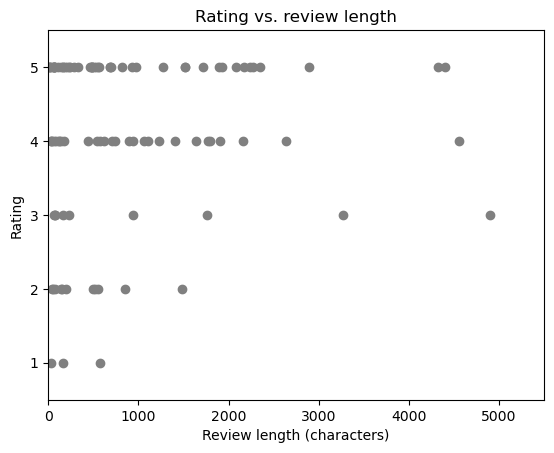

In [127]:
plt.scatter(lengths, ratings, color='grey')
plt.xlim(0, 5500)
plt.ylim(0.5, 5.5)
plt.xlabel("Review length (characters)")
plt.ylabel("Rating")
plt.title("Rating vs. review length")
plt.show()

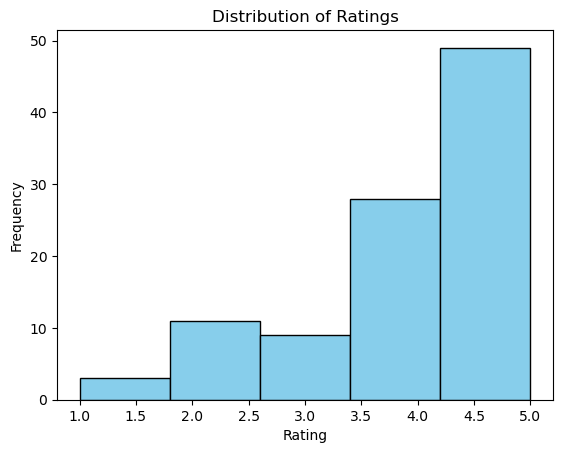

In [128]:
plt.hist(ratings, bins=5, color='skyblue', edgecolor='black')
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Ratings")
plt.show()

The histogram displays the distribution of ratings provided in the dataset. 

Shape:

The histogram is right-skewed, with the majority of the ratings clustered around the higher end (4.0–5.0).
This indicates that most users tend to give positive ratings.

Frequency of Ratings:

Rating 1.0: Very few occurrences (approximately 2–3 ratings).
Rating 2.0: Slightly higher frequency (~10 ratings), but still much less common.
Rating 3.0: Around 8–10 ratings, showing moderate frequency.
Rating 4.0: A noticeable increase, with ~30 ratings.
Rating 5.0: The most frequent rating, with approximately 50 occurrences. This category dominates the distribution.

Insights:

The skew towards higher ratings (4.0 and 5.0) suggests a general positive bias in the reviews.
Few ratings below 3.0 might indicate that users only rate items they like or that the system has a bias towards positive experiences.
The absence of significant negative ratings could mean limited diversity in feedback.

Potential Implications:

If this data is used for a predictive model (e.g., regression or classification), the model might struggle to learn patterns for low ratings due to the class imbalance.
Techniques like resampling, weighting, or synthetic data generation (e.g., SMOTE) could be used to handle this imbalance. We'll talk about this in later lectures. For now, we let this be. 

You can check out a summary of histograms here https://www.perplexity.ai/page/histograms-in-machine-learning-7ona7r4kQuug_dgeevsffw

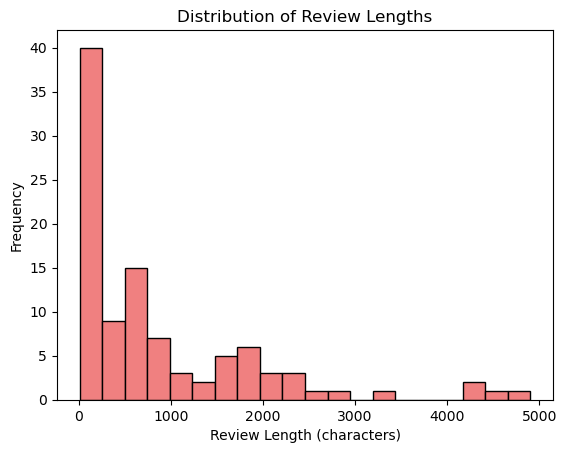

In [129]:
plt.hist(lengths, bins=20, color='lightcoral', edgecolor='black')
plt.xlabel("Review Length (characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()


### **Distribution of Review Lengths**

The histogram shows the **distribution of review lengths** (measured in characters). 

---

### **Key Observations**:
1. **Right-Skewed Distribution**:
   - The distribution is heavily **right-skewed**, meaning most reviews are **short** (under 500 characters).
   - A small number of reviews are much longer, stretching up to **5000 characters**.

2. **Frequency of Short Reviews**:
   - The majority of reviews fall into the first few bins (0–500 characters), with a sharp drop in frequency as the review length increases.
   - The first bin has the **highest frequency** (over 40 reviews), indicating very short reviews dominate the dataset.

3. **Longer Reviews**:
   - As review length increases beyond 1000 characters, the frequency drops significantly.
   - Extremely long reviews (4000–5000 characters) are **rare** outliers, appearing only a few times.

---

### **Insights**:
1. **Imbalance in Review Lengths**:
   - The dataset is dominated by shorter reviews, which may influence models that depend on text length as a feature.
   - Models might need to **normalize** or **log-transform** review lengths to reduce skewness.

2. **Outliers**:
   - Extremely long reviews could be treated as **outliers**. Further analysis can determine if they carry unique information or distort the model.

3. **Feature Engineering**:
   - Review length could be binned into categories (e.g., short, medium, long) to capture its impact on ratings.

---



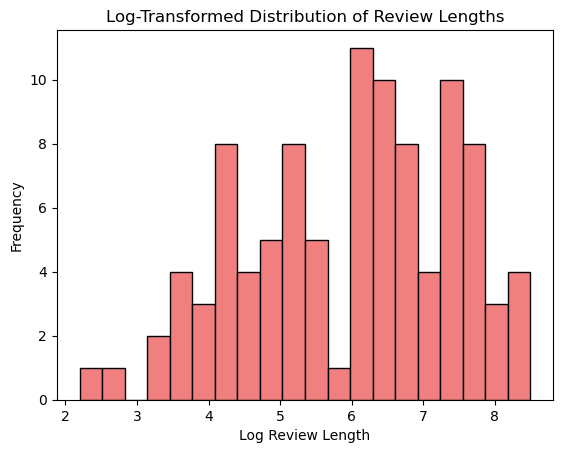

In [130]:
'''
1. Log Transformation**:
   - Apply a log transformation to reduce skewness:
     log(Review Length + 1)
'''
import numpy as np
log_lengths = np.log1p(lengths)
plt.hist(log_lengths, bins=20, color='lightcoral', edgecolor='black')
plt.title("Log-Transformed Distribution of Review Lengths")
plt.xlabel("Log Review Length")
plt.ylabel("Frequency")
plt.show()

# Compare Review Length and Ratings- explore if shorter or longer reviews correlate with higher ratings.

# Outlier Detection- Identify reviews longer than a threshold (e.g., 3000 characters for further inspection.

To perform regression, convert to features (X) and labels (y)

Over here, X is a design matrix with two columns:

Column 1: Constant term (bias) with value 1

Column 2: lengths (review lengths).


Check out pg 

In [131]:
X = numpy.asarray([[1,l] for l in lengths]) # Note the inclusion of the constant term
y = numpy.asarray(ratings).T
#Change 

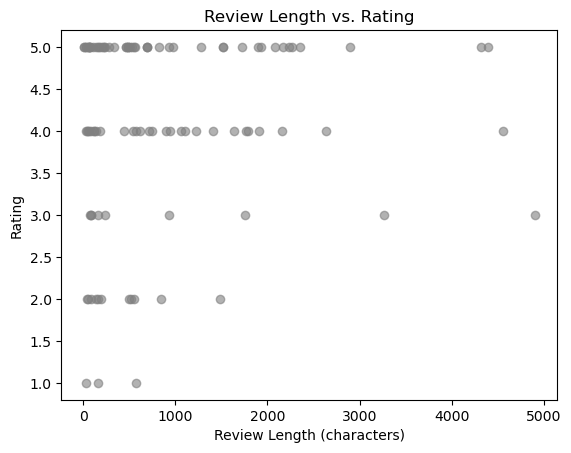

In [132]:
import matplotlib.pyplot as plt
import numpy as np

# Extract review lengths (second column of X) and ratings (y)
review_lengths = np.array(X[:, 1]).flatten()  # Column 2 of X
ratings = np.array(y).flatten()

# Scatter plot
plt.scatter(review_lengths, ratings, color='grey', alpha=0.6)
plt.xlabel("Review Length (characters)")
plt.ylabel("Rating")
plt.title("Review Length vs. Rating")
plt.show()


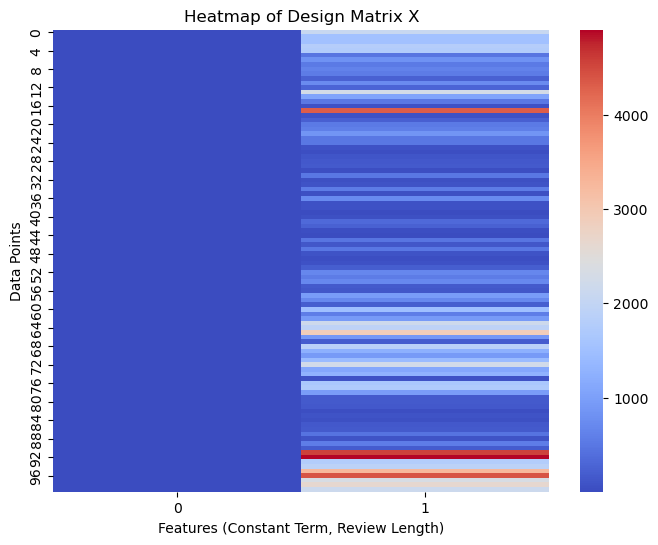

In [133]:
import seaborn as sns

# Visualize the matrix X
plt.figure(figsize=(8, 6))
sns.heatmap(np.array(X), cmap='coolwarm', cbar=True, annot=False)
plt.title("Heatmap of Design Matrix X")
plt.xlabel("Features (Constant Term, Review Length)")
plt.ylabel("Data Points")
plt.show()


<Axes: >

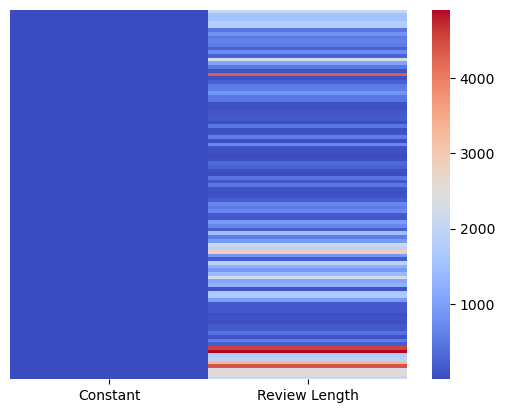

In [134]:
sns.heatmap(X, xticklabels=["Constant", "Review Length"], yticklabels=False, cmap='coolwarm')


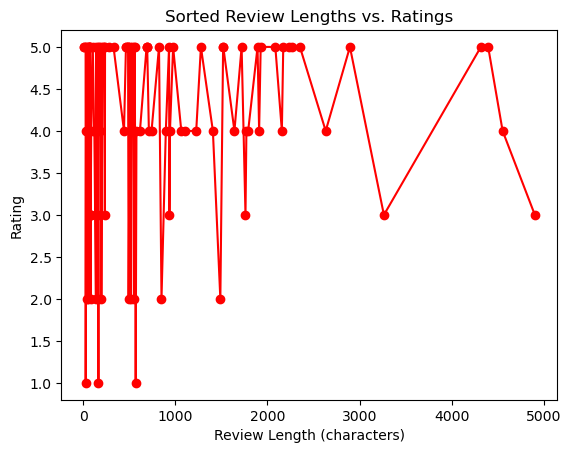

In [135]:
# Sort the data by review length
sorted_indices = np.argsort(review_lengths)
sorted_lengths = review_lengths[sorted_indices]
sorted_ratings = ratings[sorted_indices]

# Line plot
plt.plot(sorted_lengths, sorted_ratings, marker='o', linestyle='-', color='red')
plt.xlabel("Review Length (characters)")
plt.ylabel("Rating")
plt.title("Sorted Review Lengths vs. Ratings")
plt.show()


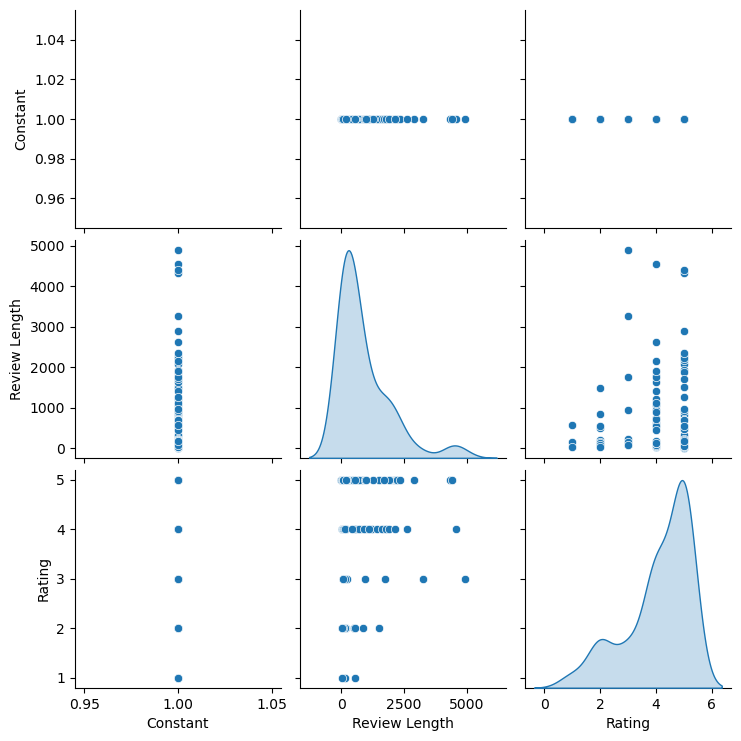

In [136]:
import pandas as pd

# Create a DataFrame
dataframe_data = pd.DataFrame({
    'Constant': np.array(X[:, 0]).flatten(),
    'Review Length': np.array(X[:, 1]).flatten(),
    'Rating': np.array(y).flatten()
})

# Pairplot
sns.pairplot(dataframe_data, diag_kind='kde')
plt.show()


In [137]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

In [138]:
theta = model.coef_
theta



array([3.98394783e+00, 1.19363599e-04])

In [139]:
theta,residuals,rank,s = numpy.linalg.lstsq(X, y, rcond=None)
theta

array([3.98394783e+00, 1.19363599e-04])

In [140]:
theta = np.linalg.inv(X.T @ X) @ X.T @ y
theta

array([3.98394783e+00, 1.19363599e-04])

This is a correction from the previous version
### **Incorrect Code**
```python
numpy.linalg.inv(X.T * X) * X.T * y
```
- `X.T * X`: Element-wise multiplication, **not valid** for matrix operations.

---

### **Solution**
Use the `@` operator for **matrix multiplication**:

```python
theta = np.linalg.inv(X.T @ X) @ X.T @ y
```

---

### **Why This Works**
1. **Matrix Multiplication**:
   - `X.T @ X`: Transpose of \( X \) multiplied by \( X \) → Shape `(2, 2)`.
   - `X.T @ y`: Transpose of \( X \) multiplied by \( y \) → Shape `(2, 1)`.

2. **Inverse**:
   - `np.linalg.inv(X.T @ X)`: Computes the inverse of \( X^T X \).

3. Multiply inverse with Transpose \( X \) multiplied by \( y \)

---

### **Key Fix**
- Replace `*` with `@` for proper matrix multiplication.

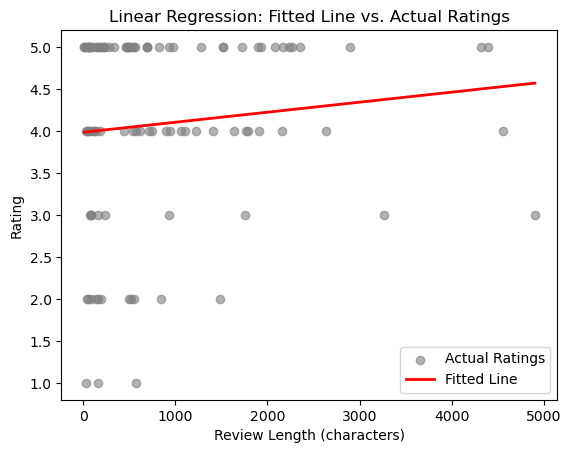

In [141]:

# Extract coefficients
theta_0 = theta[0]  # Intercept
theta_1 = theta[1]  # Slope

# Create a range of review lengths (X values)
review_lengths = np.array(X[:, 1]).flatten()
ratings = np.array(y).flatten()

# Generate predicted ratings using the fitted line
review_lengths_sorted = np.sort(review_lengths)  # Sort for a cleaner line
predicted_ratings = theta_0 + theta_1 * review_lengths_sorted

# Plot actual data points
plt.scatter(review_lengths, ratings, color='grey', alpha=0.6, label="Actual Ratings")

# Plot fitted line
plt.plot(review_lengths_sorted, predicted_ratings, color='red', linewidth=2, label="Fitted Line")

# Customize the plot
plt.xlabel("Review Length (characters)")
plt.ylabel("Rating")
plt.title("Linear Regression: Fitted Line vs. Actual Ratings")
plt.legend()
plt.show()


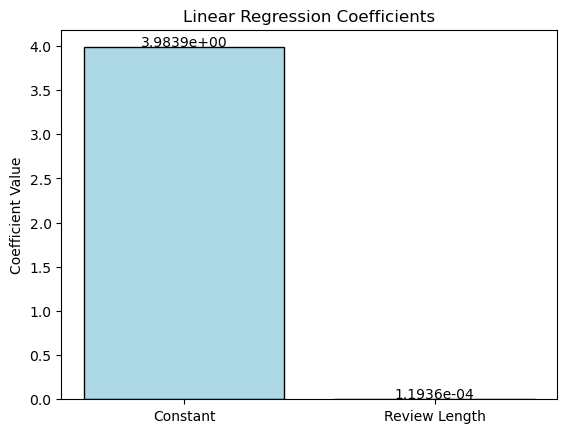

In [142]:
# Bar plot for coefficients
feature_names = ["Constant", "Review Length"]
plt.bar(feature_names, theta, color='lightblue', edgecolor='black')

# Annotate the bar values
for i, v in enumerate(theta):
    plt.text(i, v + 0.01, f"{v:.4e}", ha='center')

plt.title("Linear Regression Coefficients")
plt.ylabel("Coefficient Value")
plt.show()


In [143]:
def feature(d):
    feat = [1] # Constant feature
    feat.append(len(d['review_text'])) # Length of review
    feat.append(d['n_comments']) # Number of comments
    return feat

Weak relationship: From earlier coefficients we observed that review length has a small impact on ratings, which is why we added that second feature. 


In [144]:
X = numpy.asarray([feature(d) for d in data])

In [145]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)
theta = model.coef_
theta

array([3.95432090e+00, 7.24295694e-05, 1.08071028e-01])

In [146]:
y_pred = model.predict(X)


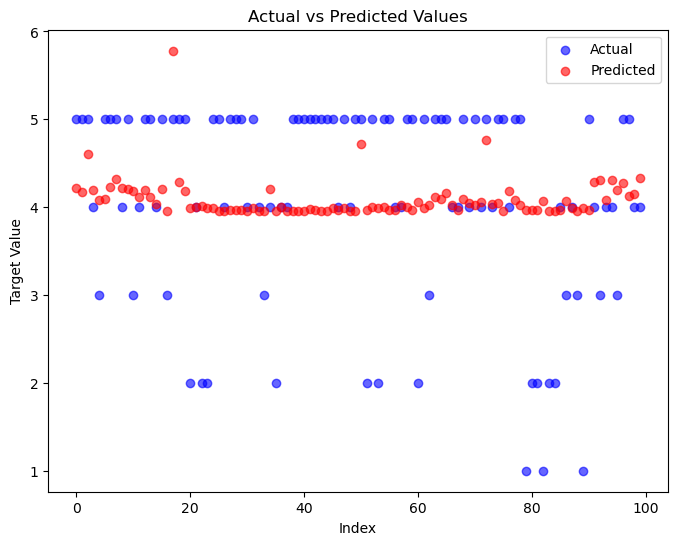

In [147]:
import matplotlib.pyplot as plt

# Actual vs Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y)), y, color='blue', label='Actual', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted', alpha=0.6)
plt.xlabel('Index')
plt.ylabel('Target Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


In [148]:
sse = sum([x**2 for x in (y - y_pred)])


In [149]:
mse = sse / len(y)
mse


1.2298886916501268

R^2 and fraction of variance unexplained (FVU)

In [150]:
fvu = mse / numpy.var(y)
r2 = 1 - fvu
r2

0.04057360819866884

In [151]:
model.score(X, y)


0.0405736081986684

### Simple feature transformations

Polynomial (quadratic) function

In [152]:
def feature(d):
    feat = [1]
    feat.append(len(d['review_text']))
    feat.append((len(d['review_text']))**2) # Quadratic term
    return feat

In [153]:
X = numpy.asarray([feature(d) for d in data])


In [154]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False) #True/False changes theta 0. You can add/edit this. 
model.fit(X, y)
theta = model.coef_ #This is an array of Theta 0, Theta 1 and Theta 2
theta

array([ 3.86513512e+00,  4.34379750e-04, -8.37700479e-08])

In [155]:
model.score(X, y)
#R^2 coefficient using sklearn library

0.026559772903043233

Cubic function



In [156]:
def feature(d):
    feat = [1]
    feat.append(len(d['review_text'])/1000)
    feat.append((len(d['review_text'])/1000)**2) # Quadratic term
    feat.append((len(d['review_text'])/1000)**3) # Cubic term
    return feat

In [157]:
X = numpy.asarray([feature(d) for d in data])


In [158]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)
theta = model.coef_
theta

array([ 3.92656525,  0.11531522,  0.14023331, -0.03494859])

In [159]:
model.score(X, y)

0.02926072167925886

## Bar plot of daily ratings trends
Use a larger dataset of ratings reviews

In [160]:
path = "fantasy_10000.json"
f = open(path)

data = []

for l in f:
    d = json.loads(l)
    data.append(d)
    
f.close()

Extract averages for each day


In [161]:
weekAverages = defaultdict(list)

for d in data:
    timeString = d['date_added']
    t = dateutil.parser.parse(timeString)
    weekAverages[t.weekday()].append(d['rating'])

for k in weekAverages:
    weekAverages[k] = sum(weekAverages[k]) / len(weekAverages[k])


In [162]:
weekAverages


defaultdict(list,
            {6: 3.755786113328013,
             2: 3.795968234575443,
             5: 3.693290734824281,
             1: 3.7186505410566517,
             0: 3.6558265582655824,
             3: 3.7673956262425445,
             4: 3.7895545314900154})

Plot the averages for each day


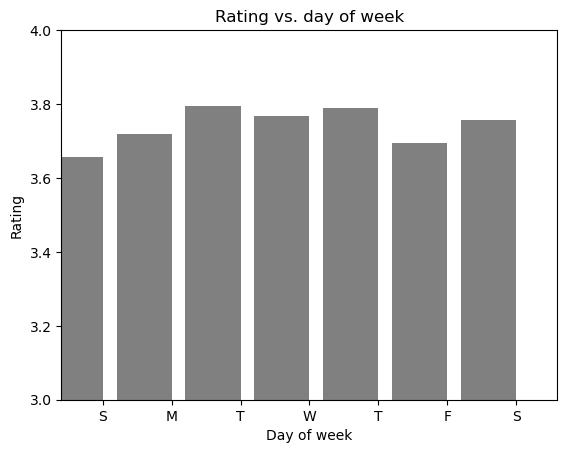

In [163]:
xplot = list(weekAverages.keys())
xplot.sort()
yplot = [weekAverages[k] for k in xplot]
plt.bar(xplot,yplot,color='grey',lw=0)
plt.xticks(numpy.arange(0.4,7.4,1), ["S", "M", "T", "W", "T", "F", "S"])
plt.xlim(-0.2,7.0)
plt.ylim(3,4)
plt.ylabel("Rating")
plt.xlabel("Day of week")
plt.title(r"Rating vs. day of week")
plt.show()


## Binary (one-hot) features
Read a small dataset of beer reviews with gender attributes


In [170]:
import json5

path = "beer_500.json"
data_2 = []

with open(path, "r") as f:
    for l in f:
        try:
            d2 = json5.loads(l.strip())
            data_2.append(d2)
        except Exception as e:
            print("Error decoding line:", e)


In [171]:
data_2[0]

{'review/appearance': 2.5,
 'beer/style': 'Hefeweizen',
 'review/palate': 1.5,
 'review/taste': 1.5,
 'beer/name': 'Sausa Weizen',
 'review/timeUnix': 1234817823,
 'beer/ABV': 5.0,
 'beer/beerId': '47986',
 'beer/brewerId': '10325',
 'review/timeStruct': {'isdst': 0,
  'mday': 16,
  'hour': 20,
  'min': 57,
  'sec': 3,
  'mon': 2,
  'year': 2009,
  'yday': 47,
  'wday': 0},
 'review/overall': 1.5,
 'review/text': 'A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.',
 'user/profileName': 'stcules',
 'review/aroma': 2.0}

Filter the dataset to include only those users who specified gender

In [172]:
data_2= [d2 for d2 in data_2 if 'user/gender' in d2]


How many users have specified gender?

In [173]:
len(data_2)

215

Binary representation of gender attribute

In [174]:
def feat(d2):
    return [1, 1.0 * (d2['user/gender'] == 'Female')]

In [176]:
X = [feat(d2) for d2 in data_2]
y = [len(d2['review/text'].split()) for d2 in data_2]

In [177]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)
theta = model.coef_
theta

array([127.07177033,   8.761563  ])

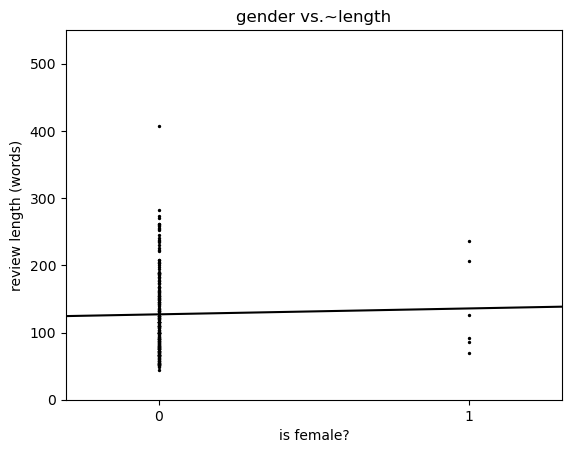

In [178]:
xplot = numpy.arange(-1,3,1)
yplot = [theta[0] + theta[1]*x for x in xplot]
plt.plot(xplot, yplot, color='k')
plt.scatter([[x[1] for x in X]], y, color='k', s=2)
plt.xlim(-0.3, 1.3)
plt.ylim(0, 550)
plt.xticks([0,1])
plt.xlabel("is female?")
plt.ylabel(r"review length (words)")
plt.title(r"gender vs.~length")
plt.show()

In [180]:
f = open("redditSubmissions.csv")
cs = csv.reader(f)
header = next(cs)
header

['#image_id',
 'unixtime',
 'rawtime',
 'title',
 'total_votes',
 'reddit_id',
 'number_of_upvotes',
 'subreddit',
 'number_of_downvotes',
 'localtime',
 'score',
 'number_of_comments',
 'username']

In [181]:
pops = defaultdict(list)
imId = None
count = 0
for l in cs:
    d = dict(zip(header, l))
    if d['#image_id'] != imId:
        count = 0
    imId = d['#image_id']
    count += 1
    try:
        pops[count].append(int(d['number_of_upvotes']))
    except Exception as e:
        continue

for x in pops:
    pops[x] = sum(pops[x]) / len(pops[x])

In [182]:
x = list(pops.keys())
x.sort()
X = [[1,a] for a in x]

In [183]:
y = [pops[a] for a in x]
ylog = [math.log2(a) for a in y]

In [184]:
mod = linear_model.LinearRegression(fit_intercept = False)
modlog = linear_model.LinearRegression(fit_intercept = False)

mod.fit(X,y)
modlog.fit(X,ylog)

theta = mod.coef_
thetalog = modlog.coef_


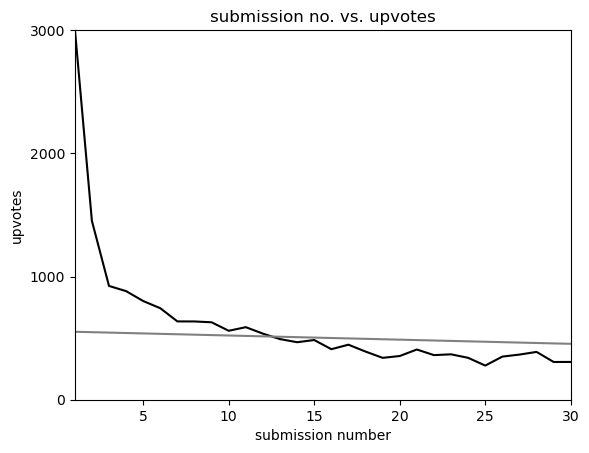

In [185]:
plt.plot(x,y,color='k')
plt.xlim(1,30)
plt.ylim(0,3000)
x1 = [0,30]
y1 = [theta[0] + theta[1]*a for a in x1]
plt.plot(x1,y1,color='grey')
plt.xlabel("submission number")
plt.ylabel("upvotes")
plt.yticks([0,1000,2000,3000])
plt.title("submission no. vs. upvotes")
plt.show()

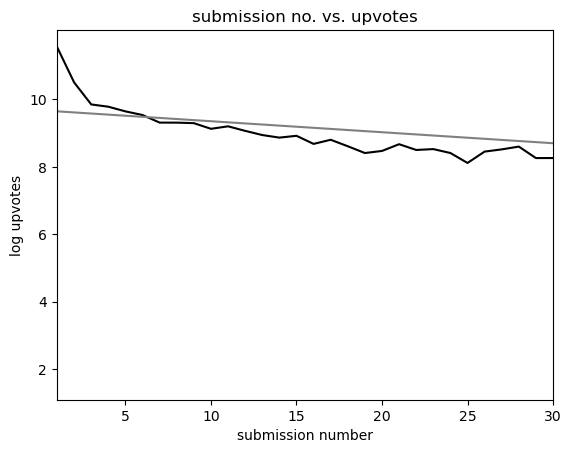

In [186]:
plt.plot(x,ylog, color='k')
plt.xlim(1,30)
x1 = [0,30]
y1 = [thetalog[0] + thetalog[1]*a for a in x1]
plt.plot(x1,y1, color='grey')
plt.xlabel("submission number")
plt.ylabel("log upvotes")
plt.yticks([2,4,6,8,10])
plt.title("submission no. vs. upvotes")
plt.show()